In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import datetime
import random
import os
import re
from collections import defaultdict

import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# !pip install numpy --upgrade

In [4]:
#!pip freeze

In [5]:
pd.__version__

'1.0.3'

### Importing data

In [8]:
def import_csv(filename, path = './data'):
    return pd.read_csv(os.path.join(path, filename))

In [9]:
test_activity = import_csv('act_test.csv')
train_activity = import_csv('act_train.csv')
people = import_csv('people.csv')

In [10]:
test_activity.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682
2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,type 1,type 13,type 10,NaN
3,ppl_10001,act1_83552,2022-11-27,type 1,type 20,type 10,type 5,type 4,type 6,type 1,type 1,type 5,type 5,NaN
4,ppl_10001,act2_1043301,2022-10-15,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 3015


In [11]:
train_activity.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [13]:
people.head()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,type 2,type 4,False,False,True,True,False,False,False,True,False,False,False,False,False,True,False,True,True,True,False,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,type 2,type 2,True,True,True,True,True,True,False,True,False,True,False,True,True,True,True,True,True,True,True,False,False,True,True,True,True,False,True,True,99
3,ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,type 2,type 2,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,76
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,type 2,type 2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,84


- Each row in the activity file represents a **unique activity** performed by a person on a certain date. Each activity has a unique activity_id.
- The activity file contains several different categories of activities. 
- **Type 1** activities are different from type 2-7 activities because there are more known chars associated with type 1 activities (**nine in total**) than type 2-7 activities (which have only one associated characteristic).
- The two files can be joined together using **person_id** as the common key. 
- All variables are categorical, with the exception of 'char_38' in the people file, which is a continuous numerical variable.

### Data cleaning

In [12]:
def _process_date(dataframe, date_col):
    """
    A private function which preprocesses datetime information.
    Input:
    - dataframe
    - name of the date column (object)
    
    Output:
    - dataframe with new date columns: month, year, weekend_flg
    """
    df = dataframe.copy()
    df['date'] = pd.to_datetime(df[date_col])
    df['month']=df['date'].dt.month
    df['year']=df['date'].dt.year
    df['weekend_flg'] = (df['date'].dt.weekday >= 5).astype(int)
    df.drop(['date'], inplace=True, axis=1)
    return df

In [13]:
def clean_people(original_df):
    """
    The aim of this function is to prepare `people` df by unifying types of data.
    The function takes in a dataframe (specifically `people`) and returns a copy of the given dataframe, but with converted data types (all ints).
    """
    df = _process_date(original_df, 'date')
    
    for col in list(df.select_dtypes(include='object').columns):
        if col.startswith("char_") or col.startswith("group_"):
            try:
                df[col] = df[col].apply(lambda x: x.split(" ")[1]).astype("int64")
                print(f"{col} converted directly to int")
            except ValueError:
                df[col] = (df[col].apply(lambda x: x.split(" ")[1]).astype("float64")).astype('int64')
                print(f"{col} converted indirectly to int")
            except IndexError:
                pass
        elif col.startswith("people_"):
            try:
                df[col] = df[col].apply(lambda x: x.split("_")[1]).astype("int64")
                print(f'{col} converted directly to int')
            except ValueError:
                df[col] = (df[col].apply(lambda x: x.split("_")[1]).astype("float64")).astype('int64')
                print(f'{col} converted indirectly to int')
    for col in list(df.select_dtypes(include=['bool', 'float64']).columns):
        try:
            df[col] = df[col].astype("int64")
            print(f"{col} converted to int")
        except AttributeError:
                print(f"Can't convert {col} to int")
    return df

In [14]:
people_df = clean_people(people)

people_id converted indirectly to int
char_1 converted directly to int
group_1 converted directly to int
char_2 converted directly to int
char_3 converted directly to int
char_4 converted directly to int
char_5 converted directly to int
char_6 converted directly to int
char_7 converted directly to int
char_8 converted directly to int
char_9 converted directly to int
char_10 converted to int
char_11 converted to int
char_12 converted to int
char_13 converted to int
char_14 converted to int
char_15 converted to int
char_16 converted to int
char_17 converted to int
char_18 converted to int
char_19 converted to int
char_20 converted to int
char_21 converted to int
char_22 converted to int
char_23 converted to int
char_24 converted to int
char_25 converted to int
char_26 converted to int
char_27 converted to int
char_28 converted to int
char_29 converted to int
char_30 converted to int
char_31 converted to int
char_32 converted to int
char_33 converted to int
char_34 converted to int
char_3

In [15]:
people_df.head()

,people_id,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month,year,weekend_flg
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0
1,100002,2,8688,3,28,9,5,3,11,2,4,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,76,1,2021,0
2,100003,2,33592,3,4,8,5,2,5,2,2,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,99,6,2022,0
3,100004,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,7,2022,0
4,100006,2,6534,3,40,25,9,3,8,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,84,7,2022,0


In [16]:
for data in [test_activity,train_activity]:
    print(data.isnull().sum())
    print("\n")

people_id                 0
activity_id               0
date                      0
activity_category         0
char_1               458595
char_2               458595
char_3               458595
char_4               458595
char_5               458595
char_6               458595
char_7               458595
char_8               458595
char_9               458595
char_10               40092
dtype: int64


people_id                  0
activity_id                0
date                       0
activity_category          0
char_1               2039676
char_2               2039676
char_3               2039676
char_4               2039676
char_5               2039676
char_6               2039676
char_7               2039676
char_8               2039676
char_9               2039676
char_10               157615
outcome                    0
dtype: int64




In [17]:
test_activity.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682
2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,type 1,type 13,type 10,NaN
3,ppl_10001,act1_83552,2022-11-27,type 1,type 20,type 10,type 5,type 4,type 6,type 1,type 1,type 5,type 5,NaN
4,ppl_10001,act2_1043301,2022-10-15,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 3015


In [18]:
#test_activity['activity_id'].apply(lambda x: x.split("_")[0]).unique()
# train_activity['activity_id'].apply(lambda x: x.split("_")[0]).unique()

In [19]:
def clean_activity(original_df):
    """
    The aim of this function is to prepare `activity` df (and test df) by unifying types of data.
    The function takes in a dataframe (specifically `activity`) and returns this dataframe, but with converted data types.
    """ 

    df = _process_date(original_df, 'date')
                               
    for col in list(df.select_dtypes(include='object').columns):
        if col.endswith("_id"):
            try:
                df[col] = df[col].apply(lambda x: x.split("_")[1]).astype("int64")
                print(f"{col} converted directly to int")
            except ValueError:
                df[col] = (df[col].apply(lambda x: x.split("_")[1]).astype("float64")).astype("int64")
                print(f"{col} converted indirectly to int")
            except IndexError:
                pass
        else:
            df[col]= df[col].fillna('type -1')
            try:
                df[col] = df[col].apply(lambda x: x.split(" ")[1]).astype("int64")
                print(f"{col} converted directly to int")
            except ValueError:
                df[col] = (df[col].apply(lambda x: x.split(" ")[1]).astype("float64")).astype('int64')
                print(f"{col} converted indirectly to int")
    for col in list(df.select_dtypes(include=['bool', 'float64']).columns):
        try:
            df[col] = df[col].astype("int64")
            print(f"{col} converted to int")
        except AttributeError:
                print(f"Can't convert {col} to int")
    return df

In [20]:
test_activity_df= clean_activity(test_activity)

people_id converted directly to int
activity_id converted indirectly to int
activity_category converted directly to int
char_1 converted directly to int
char_2 converted directly to int
char_3 converted directly to int
char_4 converted directly to int
char_5 converted directly to int
char_6 converted directly to int
char_7 converted directly to int
char_8 converted directly to int
char_9 converted directly to int
char_10 converted directly to int


In [21]:
test_activity_df.head()

,people_id,activity_id,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,month,year,weekend_flg
0,100004,249281,1,5,10,5,1,6,1,1,7,4,-1,7,2022,0
1,100004,230855,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,682,7,2022,0
2,10001,240724,1,12,1,5,4,6,1,1,13,10,-1,10,2022,0
3,10001,83552,1,20,10,5,4,6,1,1,5,5,-1,11,2022,1
4,10001,1043301,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,3015,10,2022,1


In [22]:
train_activity_df= clean_activity(train_activity)

people_id converted indirectly to int
activity_id converted indirectly to int
activity_category converted directly to int
char_1 converted directly to int
char_2 converted directly to int
char_3 converted directly to int
char_4 converted directly to int
char_5 converted directly to int
char_6 converted directly to int
char_7 converted directly to int
char_8 converted directly to int
char_9 converted directly to int
char_10 converted directly to int


In [23]:
train_activity_df.head()

,people_id,activity_id,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome,month,year,weekend_flg
0,100,1734928,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,76,0,8,2023,1
1,100,2434093,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0
2,100,3404049,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0
3,100,3651215,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,0
4,100,4109017,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,1


### Exploring `train_activity_df`

In [24]:
list(train_activity_df.columns)

['people_id',
 'activity_id',
 'activity_category',
 'char_1',
 'char_2',
 'char_3',
 'char_4',
 'char_5',
 'char_6',
 'char_7',
 'char_8',
 'char_9',
 'char_10',
 'outcome',
 'month',
 'year',
 'weekend_flg']

**Chars**

In [25]:
chars = list(train_activity_df.filter(regex= 'char_', axis=1).columns)

In [26]:
chars_acts_unique=defaultdict(int)

In [27]:
for char in chars:
    chars_acts_unique[char]= len((list(train_activity_df[char].unique())))

In [28]:
#lmax typ w każdej charakterystyce - typ 10 wyraznie odstaje od reszty
chars_acts_unique

defaultdict(int,
            {'char_1': 52,
             'char_2': 33,
             'char_3': 12,
             'char_4': 8,
             'char_5': 8,
             'char_6': 6,
             'char_7': 9,
             'char_8': 19,
             'char_9': 20,
             'char_10': 6516})

In [29]:
sns.set(rc={'figure.figsize':(10,8)})

In [30]:
SMALL_SIZE = 11
MEDIUM_SIZE = 13
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)  
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

Text(0, 0.5, 'Number of categories')

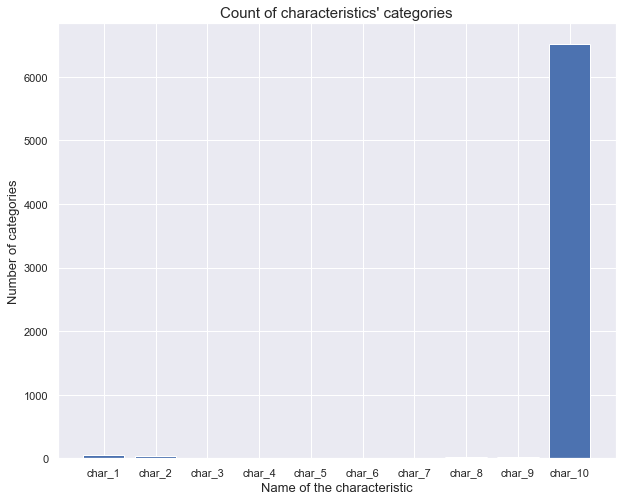

In [31]:
plt.bar(range(len(chars_acts_unique)), list(chars_acts_unique.values()), align='center')
plt.xticks(range(len(chars_acts_unique)), list(chars_acts_unique.keys()))
plt.title("Count of characteristics' categories")
plt.xlabel('Name of the characteristic')
plt.ylabel('Number of categories')

`Char_10` differs significantly from the other characteristics - it contains more than 6000 categories

In [32]:
chars_acts_unique.pop('char_10')

6516

Text(0, 0.5, 'Number of categories')

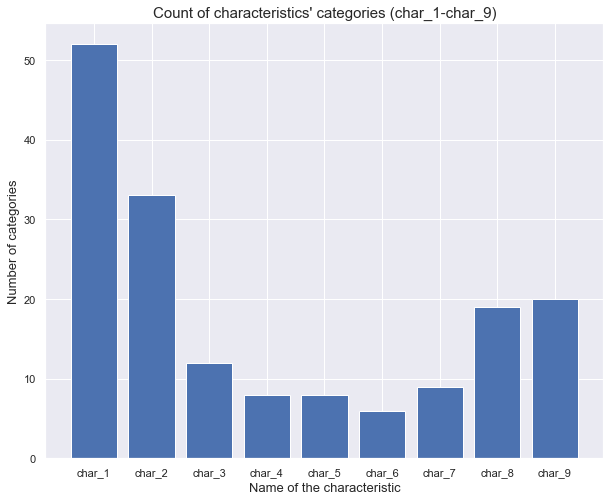

In [33]:
plt.bar(range(len(chars_acts_unique)), list(chars_acts_unique.values()), align='center')
plt.xticks(range(len(chars_acts_unique)), list(chars_acts_unique.keys()))
plt.title("Count of characteristics' categories (char_1-char_9)")
plt.xlabel('Name of the characteristic')
plt.ylabel('Number of categories')

**`char_10`**

In [34]:
char10_stats = (pd.DataFrame(train_activity_df['char_10'].value_counts().sort_values(ascending=False)).reset_index()).rename(columns={'index':'type','char_10':'count'})

In [35]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

Text(0.5, 1.0, 'Distribution of values of char_10')

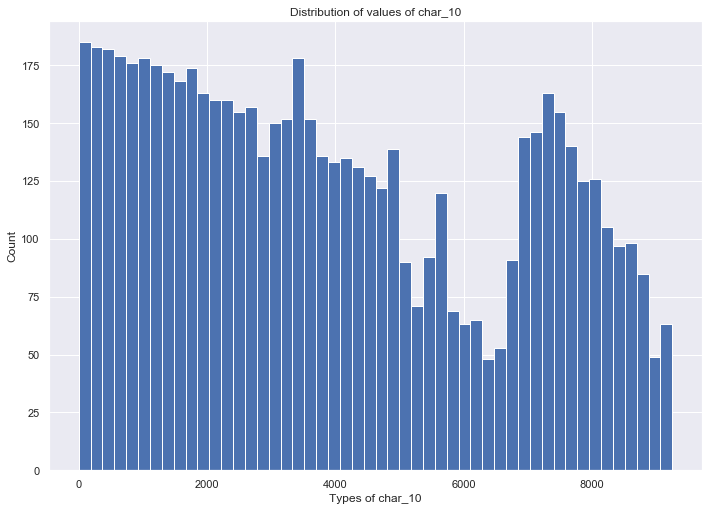

In [36]:
plt.hist(char10_stats['type'], bins=50)
plt.xlabel('Types of char_10')
plt.ylabel('Count')
plt.title('Distribution of values of char_10')

`char_10` has too many categories to encode and it will be dropped further on. 

**`char_1`-`char_9`**

In [37]:
cols = list(train_activity_df.columns)

In [38]:
chars_1_9 = [x for x in cols if x.startswith('char_') and int(x[-1]) in range(1,10)]

In [39]:
chars_1_to_9_df = train_activity_df[chars_1_9]

In [40]:
chars_1_to_9_df

,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9
0,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...
2197286,-1,-1,-1,-1,-1,-1,-1,-1,-1
2197287,-1,-1,-1,-1,-1,-1,-1,-1,-1
2197288,-1,-1,-1,-1,-1,-1,-1,-1,-1
2197289,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [41]:
#base df with max number of types available for char_1-char_9
chars_agg = pd.DataFrame({'type': range(1, np.max(list(np.max(train_activity_df[chars_1_9])))+1)})

In [42]:
for x in chars_1_9:
    y = chars_1_to_9_df[x].value_counts().reset_index(drop=False).rename(columns={"index": "type"})
    chars_agg = pd.merge(chars_agg, y, how = 'left', on = 'type')

chars_agg.sort_values(by='type',ascending=True)

,type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9
0,1,14938.000,21616.000,38224.000,27979.000,49214.000,48658.000,52548.000,11621.000,24765.000
1,2,38030.000,50524.000,6577.000,9316.000,26982.000,61026.000,32199.000,4131.000,13488.000
2,3,12372.000,9810.000,19637.000,98131.000,6013.000,46124.000,42968.000,4909.000,5958.000
3,4,1329.000,781.000,20466.000,13730.000,1995.000,1241.000,8751.000,77460.000,8325.000
4,5,34509.000,31794.000,35488.000,5520.000,5421.000,566.000,8104.000,12396.000,11021.000
5,6,2385.000,5293.000,19631.000,2929.000,67989.000,nan,10604.000,10322.000,12824.000
6,7,7312.000,2311.000,9755.000,10.000,1.000,nan,1934.000,7737.000,6031.000
7,8,2110.000,5306.000,6473.000,nan,nan,nan,507.000,6657.000,31794.000
8,9,1225.000,2578.000,1328.000,nan,nan,nan,nan,6400.000,834.000
9,10,7795.000,6932.000,31.000,nan,nan,nan,nan,3897.000,6878.000


All chars contain types 1 to 5. `char_1` has the biggest number of types (from 1 to 52)

**Chars vs `activity_category`**

In [43]:
chars_acts = pd.DataFrame()

In [44]:
for char in chars:
    x = pd.DataFrame(train_activity_df['activity_category'][train_activity_df[char]!=-1].value_counts()).reset_index().rename(columns={'index':'type_of_activity','activity_category':'count'})
    x.set_index([[char]*len(x)], inplace=True)
    chars_acts = pd.concat([chars_acts,x], axis=0)

In [45]:
chars_acts[chars_acts['type_of_activity']!=1]

,type_of_activity,count
char_10,2,904683
char_10,5,490710
char_10,3,429408
char_10,4,207465
char_10,6,4253
char_10,7,3157


The activity file contains several different categories of activities. Type 1 activities are different from type 2-7 activities because there are more known characteristics associated with type 1 activities (nine in total) than type 2-7 activities (which have only one associated characteristic). - **char_10**

**`activity_category`**

In [46]:
acts = pd.DataFrame(train_activity_df.groupby(by='activity_category')['activity_id'].nunique().reset_index()).rename(columns={'activity_id':'count'})

In [47]:
acts

,activity_category,count
0,1,157615
1,2,904683
2,3,429408
3,4,207465
4,5,490710
5,6,4253
6,7,3157


Text(0.5, 1.0, 'The distribution of activities amongst activity categories')

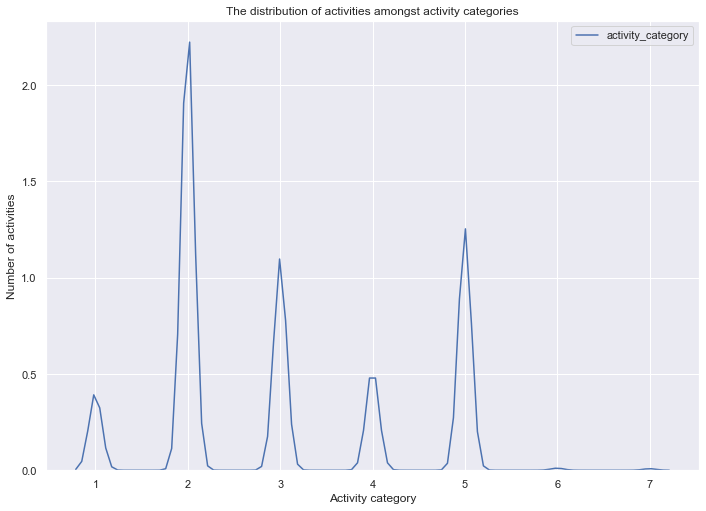

In [48]:
sns.kdeplot(train_activity_df['activity_category'])
plt.xlabel('Activity category')
plt.ylabel('Number of activities')
plt.title('The distribution of activities amongst activity categories')

Text(0.5, 1.0, 'The distribution of activities amongst activity categories')

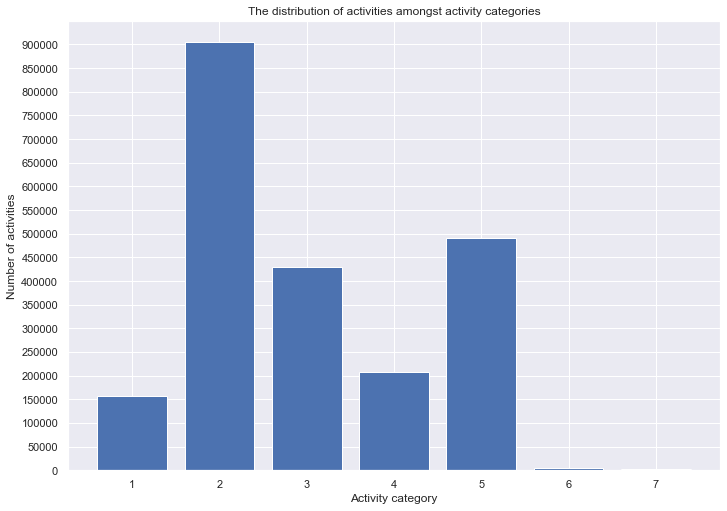

In [49]:
plt.bar(acts['activity_category'], acts['count'])
plt.yticks(list(range(0,905000,50000)))
plt.xlabel('Activity category')
plt.ylabel('Number of activities')
plt.title('The distribution of activities amongst activity categories')

### Exploring `people_df`

In [50]:
list(people_df.columns)

['people_id',
 'char_1',
 'group_1',
 'char_2',
 'char_3',
 'char_4',
 'char_5',
 'char_6',
 'char_7',
 'char_8',
 'char_9',
 'char_10',
 'char_11',
 'char_12',
 'char_13',
 'char_14',
 'char_15',
 'char_16',
 'char_17',
 'char_18',
 'char_19',
 'char_20',
 'char_21',
 'char_22',
 'char_23',
 'char_24',
 'char_25',
 'char_26',
 'char_27',
 'char_28',
 'char_29',
 'char_30',
 'char_31',
 'char_32',
 'char_33',
 'char_34',
 'char_35',
 'char_36',
 'char_37',
 'char_38',
 'month',
 'year',
 'weekend_flg']

In [51]:
people_df.head()

,people_id,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month,year,weekend_flg
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0
1,100002,2,8688,3,28,9,5,3,11,2,4,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,76,1,2021,0
2,100003,2,33592,3,4,8,5,2,5,2,2,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,99,6,2022,0
3,100004,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,7,2022,0
4,100006,2,6534,3,40,25,9,3,8,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,84,7,2022,0


In [52]:
len(list(people_df['group_1'].unique()))

34224

**chars**

In [53]:
chars_people = list(people_df.filter(regex= 'char_', axis=1).columns)

In [54]:
chars_peps_unique=defaultdict(int)

In [55]:
for char in chars_people:
    chars_peps_unique[char]= len((list(people_df[char].unique())))

In [56]:
# char_10-char_37 wylacznie dwie kategorie (czyli są to booleany)- rozklad znacznie sie rozni od tego, co jest w 'activity'
chars_peps_unique

defaultdict(int,
            {'char_1': 2,
             'char_2': 3,
             'char_3': 43,
             'char_4': 25,
             'char_5': 9,
             'char_6': 7,
             'char_7': 25,
             'char_8': 8,
             'char_9': 9,
             'char_10': 2,
             'char_11': 2,
             'char_12': 2,
             'char_13': 2,
             'char_14': 2,
             'char_15': 2,
             'char_16': 2,
             'char_17': 2,
             'char_18': 2,
             'char_19': 2,
             'char_20': 2,
             'char_21': 2,
             'char_22': 2,
             'char_23': 2,
             'char_24': 2,
             'char_25': 2,
             'char_26': 2,
             'char_27': 2,
             'char_28': 2,
             'char_29': 2,
             'char_30': 2,
             'char_31': 2,
             'char_32': 2,
             'char_33': 2,
             'char_34': 2,
             'char_35': 2,
             'char_36': 2,
             'cha

It turns out that `people_df` contains much more characteristics with different numbers of categories. `char_1` and`char_10`-`char_37` only have two categories which makes them in fact booleans. The number of categories in other characteristics varies from 3 to 101.

In [57]:
range(len(list(chars_peps_unique.keys())))

range(0, 38)

([<matplotlib.axis.XTick at 0x7f1bf6baf350>,
 <a list of 38 Text xticklabel objects>)

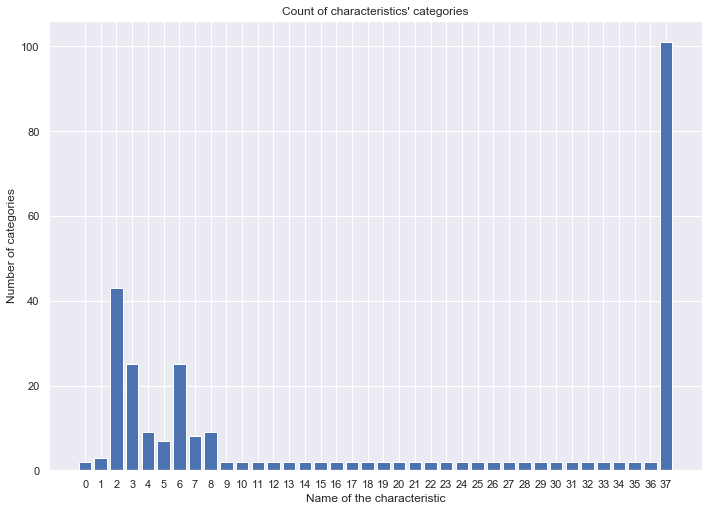

In [58]:
plt.bar(range(len(chars_peps_unique)), list(chars_peps_unique.values()), align='center')
plt.title("Count of characteristics' categories")
plt.xlabel('Name of the characteristic')
plt.ylabel('Number of categories')
plt.xticks(ticks = range(0,38,1))

**`group_1`**

`group_1` is a weird variable - no idea what that means

In [59]:
people_df.head(2)

,people_id,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month,year,weekend_flg
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0
1,100002,2,8688,3,28,9,5,3,11,2,4,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,76,1,2021,0


In [60]:
pd.DataFrame(people_df['group_1'].value_counts().reset_index()).sort_values(by='group_1', ascending=False).shape

(34224, 2)

In [61]:
pd.DataFrame(people_df['group_1'].value_counts().reset_index()).sort_values(by='group_1', ascending=False).head(2)

,index,group_1
0,17304,77314
1,667,1538


In [62]:
pd.DataFrame(people_df['group_1'].value_counts().reset_index()).sort_values(by='group_1', ascending=False).tail(2)

,index,group_1
20608,14230,1
34223,2049,1


**34224 different categories**, with the lowest count=1 and the highest count=77314

### Merging data 

In [67]:
# new, hot pandas 1.0 feature - convert_dtypes()
train_data = pd.merge(people_df, train_activity_df, how = 'left', on = 'people_id', suffixes = ('_pep', '_act')).convert_dtypes()
test_data = pd.merge(people_df, test_activity_df, how = 'left', on = 'people_id', suffixes = ('_pep', '_act')).convert_dtypes()

In [68]:
train_data.head()

,people_id,char_1_pep,group_1,char_2_pep,char_3_pep,char_4_pep,char_5_pep,char_6_pep,char_7_pep,char_8_pep,char_9_pep,char_10_pep,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month_pep,year_pep,weekend_flg_pep,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,month_act,year_act,weekend_flg_act
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,1734928,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,76,0,8,2023,1
1,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,2434093,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0
2,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,3404049,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0
3,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,3651215,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,0
4,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,4109017,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,1


In [69]:
train_data.isnull().sum()[train_data.columns[train_data.isna().any()]]

activity_id          37823
activity_category    37823
char_1_act           37823
char_2_act           37823
char_3_act           37823
char_4_act           37823
char_5_act           37823
char_6_act           37823
char_7_act           37823
char_8_act           37823
char_9_act           37823
char_10_act          37823
outcome              37823
month_act            37823
year_act             37823
weekend_flg_act      37823
dtype: int64

In [70]:
test_data.head()

,people_id,char_1_pep,group_1,char_2_pep,char_3_pep,char_4_pep,char_5_pep,char_6_pep,char_7_pep,char_8_pep,char_9_pep,char_10_pep,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month_pep,year_pep,weekend_flg_pep,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,month_act,year_act,weekend_flg_act
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,100002,2,8688,3,28,9,5,3,11,2,4,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,76,1,2021,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,100003,2,33592,3,4,8,5,2,5,2,2,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,99,6,2022,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,100004,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,7,2022,0,249281,1,5,10,5,1,6,1,1,7,4,-1,7,2022,0
4,100004,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,7,2022,0,230855,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,682,7,2022,0


In [71]:
#reszta NaNow zajme sie w preprocessingu przedmodelowym
test_data.isnull().sum()[test_data.columns[test_data.isna().any()]]

activity_id          151295
activity_category    151295
char_1_act           151295
char_2_act           151295
char_3_act           151295
char_4_act           151295
char_5_act           151295
char_6_act           151295
char_7_act           151295
char_8_act           151295
char_9_act           151295
char_10_act          151295
month_act            151295
year_act             151295
weekend_flg_act      151295
dtype: int64

### Exploring `train_data`

In [72]:
train_data.head()

,people_id,char_1_pep,group_1,char_2_pep,char_3_pep,char_4_pep,char_5_pep,char_6_pep,char_7_pep,char_8_pep,char_9_pep,char_10_pep,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month_pep,year_pep,weekend_flg_pep,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,month_act,year_act,weekend_flg_act
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,1734928,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,76,0,8,2023,1
1,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,2434093,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0
2,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,3404049,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0
3,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,3651215,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,0
4,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,4109017,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,1


In [73]:
#filling missing values with 'type -1' in `chars` 
for col in [col for col in list(train_data.columns) if (col.startswith('char_') and col.endswith('_act')) == True]:
    train_data[col]= train_data[col].fillna(-1)

In [74]:
#deleting records where outcome or activity_id are NaNs
train_data = train_data[(pd.isna(train_data['activity_id'])== False) & (pd.isna(train_data['outcome'])== False)]

In [75]:
train_data.isnull().sum()[train_data.columns[train_data.isna().any()]]

Series([], dtype: int64)

In [76]:
train_data.columns

Index(['people_id', 'char_1_pep', 'group_1', 'char_2_pep', 'char_3_pep',
       'char_4_pep', 'char_5_pep', 'char_6_pep', 'char_7_pep', 'char_8_pep',
       'char_9_pep', 'char_10_pep', 'char_11', 'char_12', 'char_13', 'char_14',
       'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20',
       'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26',
       'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32',
       'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38',
       'month_pep', 'year_pep', 'weekend_flg_pep', 'activity_id',
       'activity_category', 'char_1_act', 'char_2_act', 'char_3_act',
       'char_4_act', 'char_5_act', 'char_6_act', 'char_7_act', 'char_8_act',
       'char_9_act', 'char_10_act', 'outcome', 'month_act', 'year_act',
       'weekend_flg_act'],
      dtype='object')

In [84]:
#duplicated variables
# sorted(list(set((full.filter(regex= '_act', axis=1).columns))))

Doubled columns: `char_1`,`char_2`,`char_3`,`char_4`,`char_5`,`char_6`, `char_7`,`char_8`,`char_9`,`char_10` oraz `month`, `weekend_flg`, `year` 

All characteristics are categorical, except `char_38`

Each row represents an acitivity of a specific person (merged by `people_id`)

In [77]:
def plot_chars(dataset):
    """
    Input:
    - dataframe with characteristics (either train or test set)
    
    Output:
    -plots for each characterstic
    """
    
    cols_to_plot = list(dataset.filter(regex= 'char_', axis=1).columns)
    
    plt.figure(figsize=(20, 100))

    ax1=plt.subplot(2, 2, 1)

    for i, col in enumerate(cols_to_plot):
        plt.subplot(len(cols_to_plot)/2, 2, i+1, sharey=ax1)
        plt.subplots_adjust(hspace=0.5, wspace = 0.5)
        plt.hist(dataset[col], bins=50)
        plt.title(f"Distribution of categories for {col}")
        plt.xlabel("Category")
        plt.ylabel('Count')

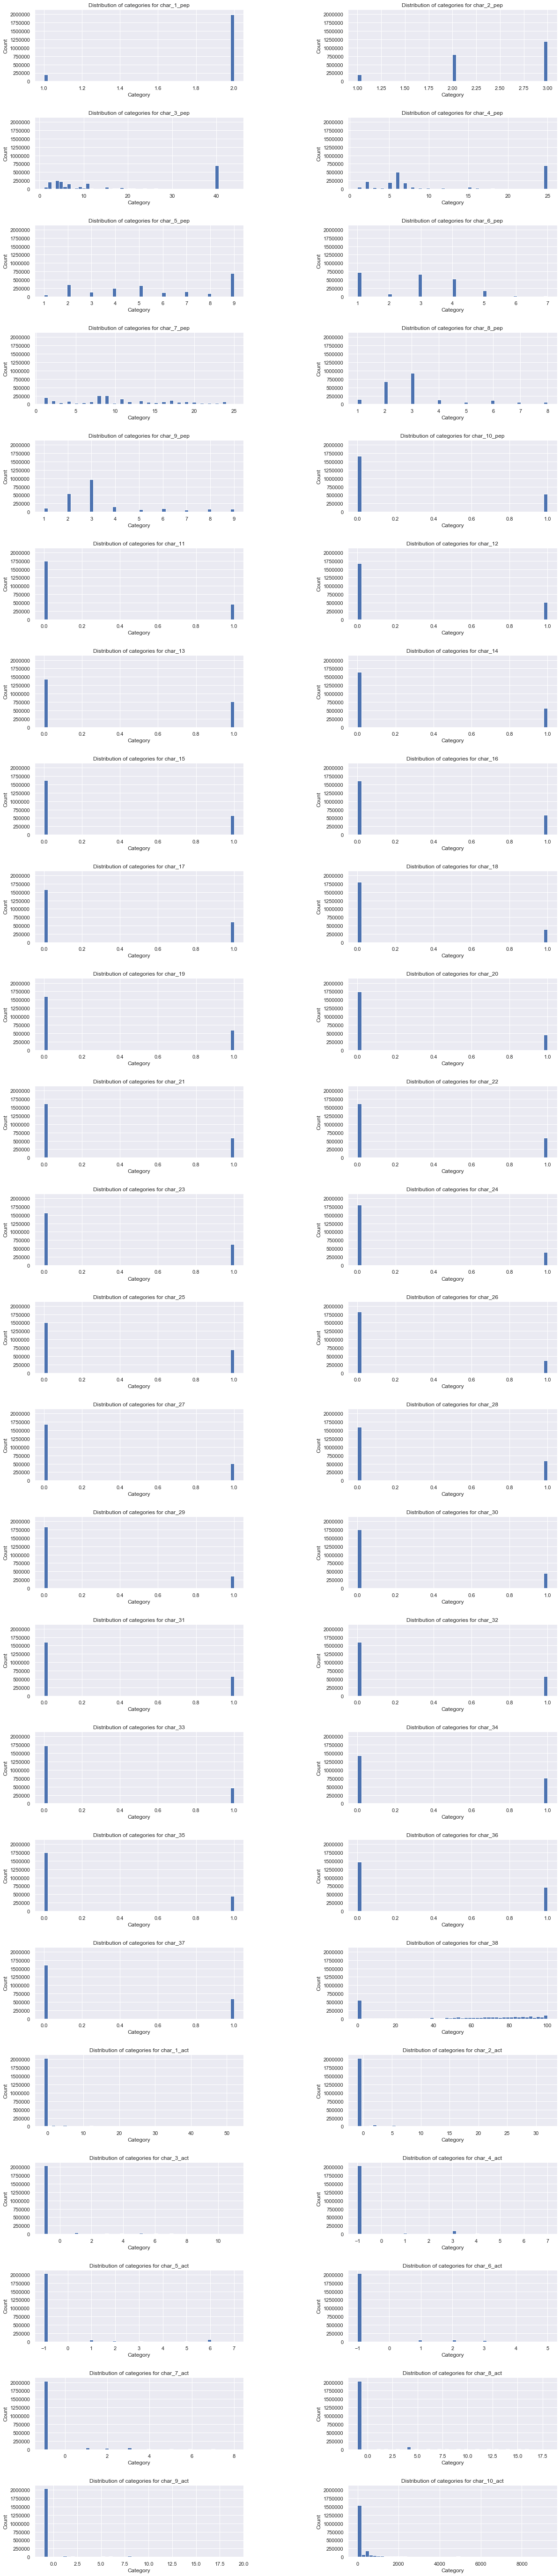

In [78]:
plot_chars(train_data)

In [79]:
#decide, what to analyze next
train_data.head(2)

,people_id,char_1_pep,group_1,char_2_pep,char_3_pep,char_4_pep,char_5_pep,char_6_pep,char_7_pep,char_8_pep,char_9_pep,char_10_pep,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month_pep,year_pep,weekend_flg_pep,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,month_act,year_act,weekend_flg_act
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,1734928,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,76,0,8,2023,1
1,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,2434093,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0


### Looking on duplicates

In [80]:
train_data.shape

(2197291, 59)

In [81]:
train_data.drop_duplicates(inplace=True)

In [82]:
train_data.shape

(2197291, 59)

No full duplicates found

**Duplicates on `activity_id`**

In [83]:
activities_cnt = pd.DataFrame(train_data['activity_id'].value_counts().reset_index()).rename(columns={'index':'activity_id', 'activity_id':'act_cnt'})

In [84]:
activities_cnt[activities_cnt['act_cnt']>1].shape[0]

68174

68174 duplicates on `activity_id`. Why?

In [85]:
#checking out the duplicates in the train_data df
train_data[train_data['activity_id'].isin(list(activities_cnt['activity_id'][activities_cnt['act_cnt']>1]))].sort_values(by='activity_id').head(15)

,people_id,char_1_pep,group_1,char_2_pep,char_3_pep,char_4_pep,char_5_pep,char_6_pep,char_7_pep,char_8_pep,char_9_pep,char_10_pep,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month_pep,year_pep,weekend_flg_pep,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,month_act,year_act,weekend_flg_act
1145072,291497,2,17304,2,19,2,5,3,8,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,1,2021,1,12,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,5,2023,0
130805,114719,2,17304,2,5,6,3,3,8,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2021,0,12,1,5,2,8,3,5,3,3,9,18,-1,0,4,2023,0
604323,198785,2,17304,2,2,6,2,4,13,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2023,0,16,1,12,1,6,3,2,2,3,4,6,-1,0,8,2023,0
588977,19606,1,283,1,1,1,1,1,1,7,7,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,90,10,2021,1,16,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,10,2022,0
612458,20012,2,17304,2,40,25,9,3,8,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,11,2022,0,21,1,5,2,3,3,5,2,2,4,3,-1,0,3,2023,1
1377158,323025,2,17304,2,40,25,9,1,7,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,2022,0,21,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,4404,0,9,2022,0
1399318,326933,2,6479,3,40,25,9,5,22,2,2,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,1,0,97,3,2022,0,36,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0
698487,215407,2,46797,3,4,6,4,3,11,2,2,1,0,1,1,0,1,1,1,0,0,0,1,1,1,0,1,0,1,1,0,1,1,1,1,1,1,1,1,89,4,2023,1,36,1,1,6,1,1,1,1,1,3,1,-1,0,4,2023,1
2128837,81439,2,7737,3,7,6,7,1,23,2,2,1,1,0,1,0,1,1,0,1,1,1,1,1,1,0,0,0,0,1,0,0,0,1,0,1,0,1,1,84,5,2022,0,37,1,5,2,2,3,1,3,3,4,17,-1,1,3,2023,0
1738891,37595,2,3873,3,40,25,9,3,11,2,2,1,1,1,1,1,1,1,1,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0,1,1,0,1,1,62,4,2021,1,37,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,9,2022,1


They are connected to different people, different characteristics and different activity categories

In [86]:
# add new column - combination of people_id and activity_id, then check on duplicates and set it as index

In [87]:
def people_activity_id_adder(df):
    df['people_act'] = df[['people_id', 'activity_id']].apply(tuple, axis=1)
    return df

In [88]:
train_data = people_activity_id_adder(train_data)

In [89]:
count_pepact = pd.DataFrame(train_data['people_act'].value_counts().reset_index()).rename(columns={'index':'people_act','people_act':'count'})

In [90]:
print(f"{count_pepact[count_pepact['count']>1].shape[0]} duplicates on people_id-activity_id")

7 duplicates on people_id-activity_id


In [91]:
train_data.drop_duplicates(subset=['people_act'], keep='last', inplace=True)

In [92]:
#check how many unique activity_id are in each month
#check how many unique activity_id are on weekends and weekdays

In [109]:
train_data.drop(columns=['char_10_act','group_1'], axis=1, inplace=True)

As stated above, `char_10` and `group_1` are deleted due to a high number of categories

In [98]:
# full = pd.concat([train_data, test_data])

In [99]:
# pd.DataFrame(full['activity_id'].value_counts().reset_index()).sort_values(by='activity_id', ascending=False).head(20)

### Model preparation